In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

jobs = pd.read_csv(r'Notebooks/jeff-jobs-cleaned-2025.csv')

# Relationship Between Hours Worked and Days Elapsed
<pre>
There is no linear relationship. 

This tells that days_elapsed has little to do with the difficulty of the job.
Could focus efforts into delays that cause a job to go unfinished.

Are these jobs being forgotten about, waiting on supplies, simply deemed unimportant? There are many possibities,
but I find this lack of a relationship notable. 
<pre>

In [2]:
filtered_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['hours_worked_flag'] != True) & (jobs['days_elapsed'].notna())] #23311 records 

filtered_jobs['days_elapsed'].corr(filtered_jobs['total_hours_worked']) #-0.0565

-0.056507522812865814

# Hours Worked By Equipment Nomenclature

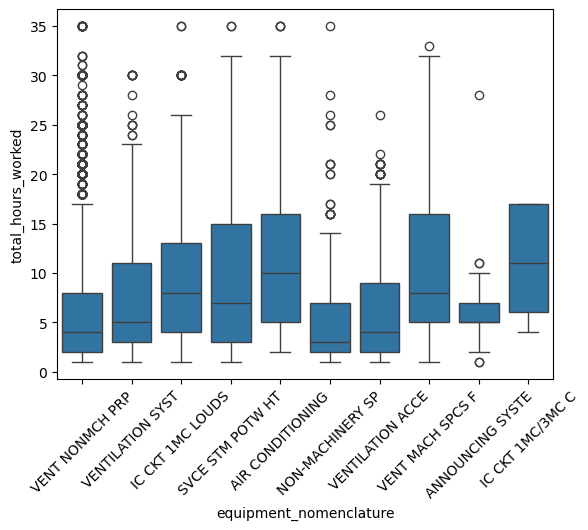

In [42]:
top10 = filtered_jobs['equipment_nomenclature'].value_counts().nlargest(10).index
df_top10 = filtered_jobs[filtered_jobs['equipment_nomenclature'].isin(top10)]

sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', data = df_top10)
plt.xticks(rotation = 45)
plt.show()
#All have at least 188 records
#Shows some sign of relationship between equipment being worked on and # of hours required to complete MA 


In [ ]:
#ANOVA 
model = ols('total_hours_worked ~ C(equipment_nomenclature)', data = df_top10).fit()
#model.rsquared = .045. No meaningful relationship
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                  sum_sq       df          F         PR(>F)
C(equipment_nomenclature)   27644.521118      9.0  84.332587  7.283757e-154
Residual                   584328.031302  16043.0        NaN            NaN


<pre>
Very little predictive power using equipment_nomenclature to predict total_hours_worked
<pre>

# Next Idea Here